In [1]:
# Import relevant packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
import time
import seaborn as sns
import random
import math

### Read predictions

In [2]:
import os
os.chdir('/mnt/guanabana/raid/home/slomp006')

## Define predictions
# RF predictions
# pred2015 = pd.read_csv("Output/RF/RFpredict2015.csv")
# pred2016 = pd.read_csv("Output/RF/RFpredict2016.csv")
# pred2017 = pd.read_csv("Output/RF/RFpredict2017.csv")
# pred2018 = pd.read_csv("Output/RF/RFpredict2018.csv")

# LSTM predictions
LSTM_pred = pd.read_csv('Output/LSTM/LSTM_pred.csv')

# Split down by year
pred2015 = pd.read_csv("Output/LSTM/predict2015.csv")
pred2016 = pd.read_csv("Output/LSTM/predict2016.csv")
pred2017 = pd.read_csv("Output/LSTM/predict2017.csv")
pred2018 = pd.read_csv("Output/LSTM/predict2018.csv")


In [3]:
## Harmonise predictions
# Remove NaN predictions
pred2015 = pred2015.dropna()
pred2016 = pred2016.dropna()
pred2017 = pred2017.dropna()
pred2018 = pred2018.dropna()

# Prediction don't have the same length. Use similar IDs.
common_ids = set(pred2015['location_id']).intersection(pred2016['location_id'], pred2017['location_id'], pred2018['location_id'])

# Filter the DataFrames to only include rows with common id values
pred2015 = pred2015[pred2015['location_id'].isin(common_ids)]
pred2016 = pred2016[pred2016['location_id'].isin(common_ids)]
pred2017 = pred2017[pred2017['location_id'].isin(common_ids)]
pred2018 = pred2018[pred2018['location_id'].isin(common_ids)]

# Sort similarly
pred2015 = pred2015.sort_values(by=['location_id'])
pred2016 = pred2016.sort_values(by=['location_id'])
pred2017 = pred2017.sort_values(by=['location_id'])
pred2018 = pred2018.sort_values(by=['location_id'])

# Only use the class columns
classes = ['tree', 'shrub', 'grassland', 'crops', 
           'urban_built_up', 'bare', 'water']
# ids = ['sample_id', 'location_id', 'x', 'y']
ids = ['location_id'] # LSTM predictions don't contain x and y, dense RF does not have sample id (fix maybe)

# Retain copy and IDs for later
pred2015_copy = pred2015.copy()
pred2016_copy = pred2016.copy()
pred2017_copy = pred2017.copy()
pred2018_copy = pred2018.copy()

id2015 = pred2015[ids]
id2016 = pred2016[ids]
id2017 = pred2017[ids]
id2018 = pred2018[ids]

# Use only class columns as input for Markov Chain
pred2015 = pred2015[classes]
pred2016 = pred2016[classes]
pred2017 = pred2017[classes]
pred2018 = pred2018[classes]

In [4]:
print(pred2015.shape, pred2016.shape, pred2017.shape, pred2018.shape)

(30489, 7) (30489, 7) (30489, 7) (30489, 7)


### Read training 

In [5]:
traindf = pd.read_csv("Input/Change/train20152018.csv")

df2015 = traindf.loc[traindf['reference_year'] == 2015]
df2016 = traindf.loc[traindf['reference_year'] == 2016]
df2017 = traindf.loc[traindf['reference_year'] == 2017]
df2018 = traindf.loc[traindf['reference_year'] == 2018]

# Again, only use class columns
df2015 = df2015[df2015.columns.intersection(classes)]
df2016 = df2016[df2015.columns.intersection(classes)]
df2017 = df2017[df2015.columns.intersection(classes)]
df2018 = df2018[df2015.columns.intersection(classes)]

Create cooccurence matrix (how do classes relate with each other). To do so, create binary data frame and normalise data. Transpose to get the matrix.

In [6]:
# New coocc normalise before multiplication with transpose

binary = (df2015 > 0).astype(int)
rawnorm = df2015.apply(lambda x: (x)/np.sqrt((x**2).sum()))

znorm = rawnorm.T.dot(rawnorm)
znorm > 0
znorm

,bare,crops,grassland,shrub,tree,urban_built_up,water
bare,1.000000,0.021370,0.062976,0.044269,0.019209,0.031382,0.018673
crops,0.021370,1.000000,0.030088,0.053612,0.038120,0.046986,0.003126
grassland,0.062976,0.030088,1.000000,0.199851,0.099501,0.057267,0.019905
shrub,0.044269,0.053612,0.199851,1.000000,0.125819,0.050397,0.008756
tree,0.019209,0.038120,0.099501,0.125819,1.000000,0.080258,0.012894
urban_built_up,0.031382,0.046986,0.057267,0.050397,0.080258,1.000000,0.006469
water,0.018673,0.003126,0.019905,0.008756,0.012894,0.006469,1.000000


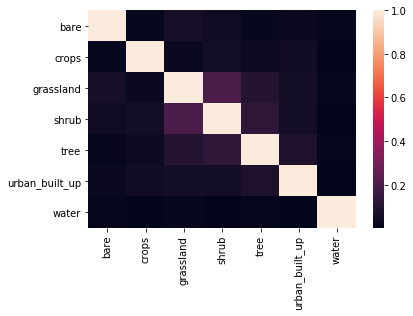

In [7]:
sns.heatmap(znorm)

## Build Markov chain

Run necessary functions first

In [8]:
# optimise_node

def optimise_node(node, edges, edges_within, stepsize=5):

    # describe edges
    e = calc_energy(node, edges, edges_within)
    
    # Create empty list to keep track of energy
    eSim = []
    eSim.append(e)

    node = minimise_energy(node, edges, edges_within, eSim, stepsize)

    return node

In [9]:
def calc_energy(node, edges, edges_within):
    
    param = 0.01
    e_coocc = edges_within * node * param
    
    
    # Old below
    edge1 = edges[0]
    edge2 = edges[1]
    
    e1 = (node - edge1)**2
    e2 = (node - edge2)**2
    
    if len(edges) == 3:
        edge3 = edges[2]
        e3 = (node - edge3)**2
        return e1 + e2 + e_coocc + e3
    
    return e1 + e2 + e_coocc

def calc_total_energy(nodes, edges, edges_within):
    
    node2015 = nodes[0]
    node2016 = nodes[1]
    node2017 = nodes[2]
    node2018 = nodes[3]
    
    edges2015 = edges[0]
    edges2016 = edges[1]
    edges2017 = edges[2]
    edges2018 = edges[3]
    
    edges_within2015 = edges_within[0]
    edges_within2016 = edges_within[1]
    edges_within2017 = edges_within[2]
    edges_within2018 = edges_within[3]
    
    e2015 = calc_energy(node2015, edges2015, edges_within2015)
    e2016 = calc_energy(node2016, edges2016, edges_within2016)
    e2017 = calc_energy(node2017, edges2017, edges_within2017)
    e2018 = calc_energy(node2018, edges2018, edges_within2018)
    
    return e2015 + e2016 + e2017 + e2018

def minimise_energy(node, edges, edges_within, eSim, stepsize):
    
    i = 0
    #print(i)
    
    if calc_energy(node + stepsize, edges, edges_within) < eSim[i] and (node + stepsize) <= 100:
        node = node + stepsize
        i += 1
        eSim.append(calc_energy(node, edges, edges_within))
        
        while calc_energy(node + stepsize, edges, edges_within) < eSim[i] and (node + stepsize) <= 100:
            node = node + stepsize
            i += 1
            eSim.append(calc_energy(node,edges, edges_within))
        
    elif calc_energy(node - stepsize, edges, edges_within) < eSim[i] and (node - stepsize) >= 0:
        node = node - stepsize
        i += 1
        eSim.append(calc_energy(node, edges, edges_within))
        
        while calc_energy(node - stepsize, edges, edges_within) < eSim[i] and (node - stepsize) >= 0:
            node = node - stepsize
            i += 1
            eSim.append(calc_energy(node, edges, edges_within))
    
    return node

In [10]:
def plot_simulations(eTotal, nodeSim2015, nodeSim2016, nodeSim2017, nodeSim2018):

    # Plot energy over iterations
    xs = [x for x in range(len(eTotal))]
    plt.figure(figsize=(15,6), dpi= 100)
    plt.subplot(1, 3, 1)
    plt.plot(xs, eTotal)
    plt.ylabel('Energy', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)

    # Plot nodes over iterations
    xs = [x for x in range(len(nodeSim2015))]
    plt.subplot(1, 3, 2)
    plt.plot(xs, nodeSim2015)
    plt.plot(xs, nodeSim2016)
    plt.plot(xs, nodeSim2017)
    plt.plot(xs, nodeSim2018)
    plt.ylabel('Fraction', fontsize=14)
    plt.xlabel('Iterations', fontsize=14)
    plt.legend(["2015","2016","2017","2018"], loc="upper left", bbox_to_anchor=(1, 0.5))

    xs = ["2015","2016","2017","2018"]
    yRF = [rf2015,rf2016,rf2017,rf2018]
    yNode = [node2015,node2016,node2017,node2018]
    plt.subplot(1, 3, 3)
    plt.plot(xs, yRF)
    plt.plot(xs, yNode)
    plt.ylabel('Fractions', fontsize=14)
    plt.xlabel('Years', fontsize=14)
    plt.legend(["Before","After"], loc="upper left", bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.show()

In [11]:
# How to change the paramters to get the optimal output:

# Coocc new 01:
# stepsize = 1
# param = 0.1

# Coocc new 001:
# stepsize = 1
# param = 0.01

# Coocc new 0001:
# stepsize = 1
# param = 0.001

Previous values:
          tree      shrub  grassland     crops  urban_built_up      bare     water
2015  0.278272  12.283800  86.518044  0.477837        0.027411  0.412819  0.001804
2016  0.553892  24.740574  72.587372  1.696812        0.026747  0.392831  0.001774
2017  1.580797  26.422647  67.016998  4.404505        0.042479  0.528938  0.003632
2018  2.530559  22.560644  63.924915  9.861299        0.112616  0.983207  0.026758

New values:
          bare     crops  grassland      shrub      tree  urban_built_up  \
2015  0.012819  0.077837  80.118044  16.383800  0.078272        0.027411   
2016  0.092831  1.096812  73.787372  21.240574  0.053892        0.026747   
2017  0.028938  3.304505  68.916998  23.222647  0.480797        0.042479   
2018  0.083207  5.861299  66.224915  22.560644  0.930559        0.012616   

         water  
2015  0.001804  
2016  0.001774  
2017  0.003632  
2018  0.026758  

 2015    96.699987
2016    96.300003
2017    95.999997
2018    95.699998
dtype: float64


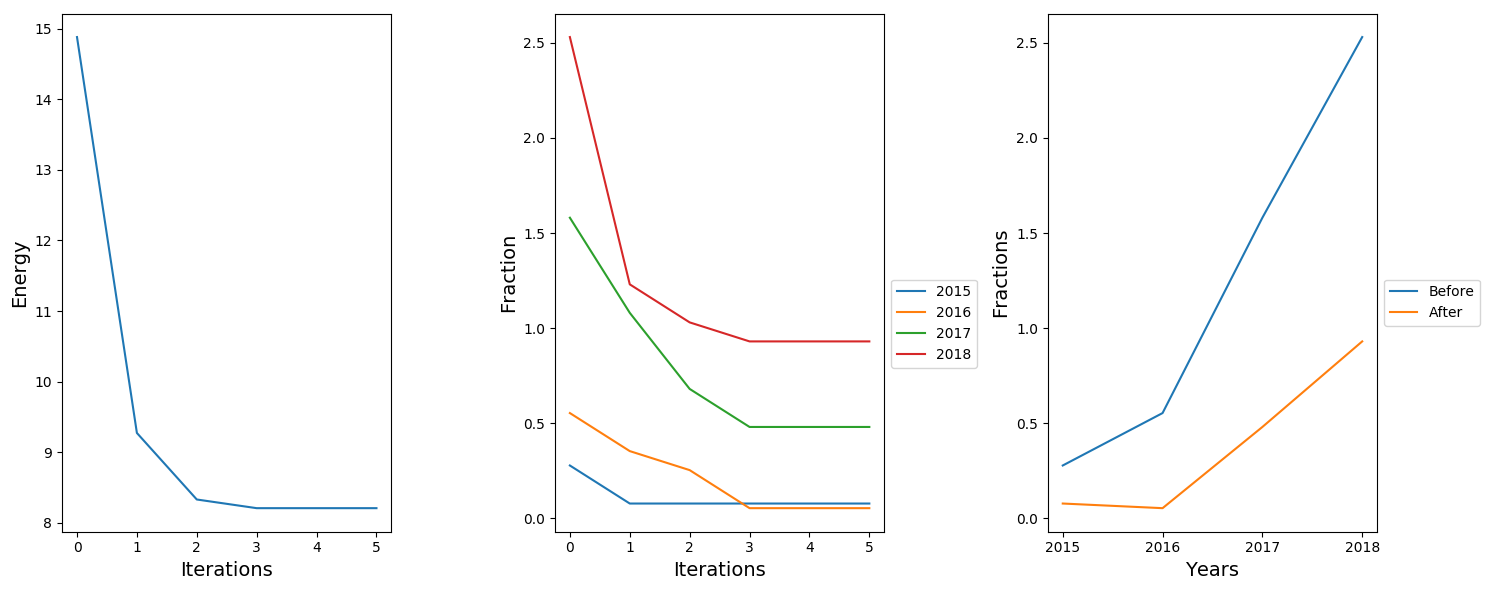

In [12]:
# Apply Markov chain model on ONE point only and check results.
t0 = time.time() # timer

i=1383

listofdicts = [dict(pred2015.iloc[i]),dict(pred2016.iloc[i]),dict(pred2017.iloc[i]),dict(pred2018.iloc[i])]
point_data = pd.DataFrame([pred2015.iloc[i],pred2016.iloc[i],pred2017.iloc[i],pred2018.iloc[i]], 
                          index=[2015, 2016, 2017, 2018])
print("Previous values:")
print(point_data.to_string())
#      tree shrub grass crops ... 
# 2015
# 2016
# 2017
# 2018

random.shuffle(classes)

# for j in classes:...
#j=1
for j in range(len(classes)):
    
    #initialise    
    rf2015 = listofdicts[0][classes[j]]
    rf2016 = listofdicts[1][classes[j]]
    rf2017 = listofdicts[2][classes[j]]
    rf2018 = listofdicts[3][classes[j]]
    
    node2015 = rf2015
    node2016 = rf2016
    node2017 = rf2017
    node2018 = rf2018

    # Stepsize to find optimal fraction
    stepsize = .1
    plot = True

    # Keep track of nodes over iterations (useful to check with plot=True)
    nodeSim2015 = []
    nodeSim2016 = []
    nodeSim2017 = []
    nodeSim2018 = []
    nodeSim2015.append(node2015)
    nodeSim2016.append(node2016)
    nodeSim2017.append(node2017)
    nodeSim2018.append(node2018)

    # Within-year classes
    otherClasses = classes[:j] + classes[j+1:]
    #print("\nOther classes:", otherClasses)
    other2015 = {key: listofdicts[0][key] for key in otherClasses}
    other2016 = {key: listofdicts[1][key] for key in otherClasses}
    other2017 = {key: listofdicts[2][key] for key in otherClasses}
    other2018 = {key: listofdicts[3][key] for key in otherClasses}
   

    # Within-year energy 2015
    corr = znorm.loc[classes[j]][other2015.keys()]
    log = corr.apply(lambda x: -math.log(x))
    keys = list(log.index)
    within2015 = sum([other2015[key] * log[key] for key in keys])

    # Within-year energy 2016
    corr = znorm.loc[classes[j]][other2016.keys()]
    log = corr.apply(lambda x: -math.log(x))
    keys = list(log.index)
    within2016 = sum([other2016[key] * log[key] for key in keys])
    
    # Within-year energy 2017
    corr = znorm.loc[classes[j]][other2017.keys()]
    log = corr.apply(lambda x: -math.log(x))
    keys = list(log.index)
    within2017 = sum([other2017[key] * log[key] for key in keys])
    
    # Within-year energy 2018
    corr = znorm.loc[classes[j]][other2018.keys()]
    log = corr.apply(lambda x: -math.log(x))
    keys = list(log.index)
    within2018 = sum([other2018[key] * log[key] for key in keys])
    
    
    t1 = time.time()

    eTotal = []
    eTotal.append(calc_total_energy(nodes = (node2015, node2016, node2017, node2018),
                                    edges = ((rf2015,node2016),
                                             (rf2016,node2015,node2017),
                                             (rf2017,node2016,node2018),
                                             (rf2018,node2017)),
                                    edges_within = (within2015,within2016,within2017,within2018)))

    e = calc_total_energy(nodes = (node2015, node2016, node2017, node2018),
                          edges = ((rf2015,node2016),
                                   (rf2016,node2015,node2017),
                                   (rf2017,node2016,node2018),
                                   (rf2018,node2017)),
                          edges_within = (within2015,within2016,within2017,within2018))
    #print(e) # now edges_wihtin implemented in calc_energy and calc_total_energy
    # todo: implement in optimise_node and minimise_node -> done

    
    
    
    t2 = time.time()

    
    
    
    
    # Iterations over one chain
    for k in range(10):

        
        # Stop if total energy remains stable 3 iterations in a row
        if len(eTotal) >= 5 and eTotal[k] == eTotal[k-1] == eTotal[k-2]:
            break

        # Optimise node's value of 2015
        node2015 = optimise_node(node2015, edges=(rf2015,node2016), edges_within=within2015, stepsize=stepsize)
        nodeSim2015.append(node2015)
        
        # Optimise node's value of 2016
        node2016 = optimise_node(node2016, edges=(rf2016,node2015,node2017), edges_within=within2016, stepsize=stepsize)
        nodeSim2016.append(node2016)

        # Optimise node's value of 2017
        node2017 = optimise_node(node2017, edges=(rf2017,node2016,node2018), edges_within=within2017, stepsize=stepsize)
        nodeSim2017.append(node2017)

        # Optimise node's value of 2018
        node2018 = optimise_node(node2018, edges=(rf2018,node2017), edges_within=within2018, stepsize=stepsize)
        nodeSim2018.append(node2018)            
            
        # Calculate and store new total energy
        nodes = (node2015, node2016, node2017, node2018)
        edges = ((rf2015,node2016),(rf2016,node2015,node2017),(rf2017,node2016,node2018),(rf2018,node2017))
        e = calc_total_energy(nodes,edges,(within2015,within2016,within2017,within2018))
        eTotal.append(e)

    
    # print(" Final node 2015:", node2015)
    # print(" Final node 2016:", node2016)
    # print(" Final node 2017:", node2017)
    # print(" Final node 2018:", node2018,"\n")

    # update point_data with optimised nodes
    listofdicts[0][classes[j]] = node2015
    listofdicts[1][classes[j]] = node2016
    listofdicts[2][classes[j]] = node2017
    listofdicts[3][classes[j]] = node2018
    

print("\nNew values:")
#print(point_data.to_string())

print(pd.DataFrame(listofdicts, index=(2015,2016,2017,2018)))

print("\n",pd.DataFrame(listofdicts, index=(2015,2016,2017,2018)).sum(axis=1))


t3 = time.time() # timer
print("\nTotal run time:", t3-t0)
print("Part run time", t2-t1)





# Now done for one class
# TODO: make it applicable for all classes of this point
if plot == True:
    plot_simulations(eTotal, nodeSim2015, nodeSim2016, nodeSim2017, nodeSim2018)


### Run Markov chain

In [13]:
from tqdm import tqdm

# Run on all/part points

# Set up
smooth2015 = []
smooth2016 = []
smooth2017 = []
smooth2018 = []
t0 = time.time() # timer

# Loop over samples
with tqdm(total=len(pred2015), desc='Running Markov Chain...', position=0, leave=True) as pbar:
    
    for i in tqdm(range(len(pred2015)), desc='Running Markov Chain...', position=0, leave=True):
        
        # Progressbar
        pbar.update()

        listofdicts = [dict(pred2015.iloc[i]),dict(pred2016.iloc[i]),dict(pred2017.iloc[i]),dict(pred2018.iloc[i])]

        random.shuffle(classes)

        for j in range(len(classes)):

            #initialise    
            rf2015 = listofdicts[0][classes[j]]
            rf2016 = listofdicts[1][classes[j]]
            rf2017 = listofdicts[2][classes[j]]
            rf2018 = listofdicts[3][classes[j]]

            node2015 = rf2015
            node2016 = rf2016
            node2017 = rf2017
            node2018 = rf2018

            # Stepsize to find optimal fraction
            stepsize = 1
            plot = False

            # Keep track of nodes over iterations (useful to check with plot=True)
            nodeSim2015 = []
            nodeSim2016 = []
            nodeSim2017 = []
            nodeSim2018 = []
            nodeSim2015.append(node2015)
            nodeSim2016.append(node2016)
            nodeSim2017.append(node2017)
            nodeSim2018.append(node2018)

            # Within-year classes
            otherClasses = classes[:j] + classes[j+1:]
            other2015 = {key: listofdicts[0][key] for key in otherClasses}
            other2016 = {key: listofdicts[1][key] for key in otherClasses}
            other2017 = {key: listofdicts[2][key] for key in otherClasses}
            other2018 = {key: listofdicts[3][key] for key in otherClasses}

            # Within-year energy 2015
            corr = znorm.loc[classes[j]][other2015.keys()]
            log = corr.apply(lambda x: -math.log(x))
            keys = list(log.index)
            within2015 = sum([other2015[key] * log[key] for key in keys])

            # Within-year energy 2016
            corr = znorm.loc[classes[j]][other2016.keys()]
            log = corr.apply(lambda x: -math.log(x))
            keys = list(log.index)
            within2016 = sum([other2016[key] * log[key] for key in keys])

            # Within-year energy 2017
            corr = znorm.loc[classes[j]][other2017.keys()]
            log = corr.apply(lambda x: -math.log(x))
            keys = list(log.index)
            within2017 = sum([other2017[key] * log[key] for key in keys])

            # Within-year energy 2018
            corr = znorm.loc[classes[j]][other2018.keys()]
            log = corr.apply(lambda x: -math.log(x))
            keys = list(log.index)
            within2018 = sum([other2018[key] * log[key] for key in keys])

            eTotal = []
            eTotal.append(calc_total_energy(nodes = (node2015, node2016, node2017, node2018),
                                            edges = ((rf2015,node2016),
                                                     (rf2016,node2015,node2017),
                                                     (rf2017,node2016,node2018),
                                                     (rf2018,node2017)),
                                            edges_within = (within2015,within2016,within2017,within2018)))

            e = calc_total_energy(nodes = (node2015, node2016, node2017, node2018),
                                  edges = ((rf2015,node2016),
                                           (rf2016,node2015,node2017),
                                           (rf2017,node2016,node2018),
                                           (rf2018,node2017)),
                                  edges_within = (within2015,within2016,within2017,within2018))


            # Iterations over one chain
            for k in range(10):

                # Stop if total energy remains stable 3 iterations in a row
                if len(eTotal) >= 5 and eTotal[k] == eTotal[k-1] == eTotal[k-2]:
                    break

                # Optimise node's value of 2015
                node2015 = optimise_node(node2015, edges=(rf2015,node2016), edges_within=within2015, stepsize=stepsize)
                nodeSim2015.append(node2015)

                # Optimise node's value of 2016
                node2016 = optimise_node(node2016, edges=(rf2016,node2015,node2017), edges_within=within2016, stepsize=stepsize)
                nodeSim2016.append(node2016)

                # Optimise node's value of 2017
                node2017 = optimise_node(node2017, edges=(rf2017,node2016,node2018), edges_within=within2017, stepsize=stepsize)
                nodeSim2017.append(node2017)

                # Optimise node's value of 2018
                node2018 = optimise_node(node2018, edges=(rf2018,node2017), edges_within=within2018, stepsize=stepsize)
                nodeSim2018.append(node2018)            

                # Calculate and store new total energy
                nodes = (node2015, node2016, node2017, node2018)
                edges = ((rf2015,node2016),(rf2016,node2015,node2017),(rf2017,node2016,node2018),(rf2018,node2017))
                e = calc_total_energy(nodes,edges,(within2015,within2016,within2017,within2018))
                eTotal.append(e)

            # update point_data with optimised nodes
            listofdicts[0][classes[j]] = node2015
            listofdicts[1][classes[j]] = node2016
            listofdicts[2][classes[j]] = node2017
            listofdicts[3][classes[j]] = node2018


        # Save updated values in list
        smooth2015.append([fraction for fraction in listofdicts[0].values()])
        smooth2016.append([fraction for fraction in listofdicts[1].values()])
        smooth2017.append([fraction for fraction in listofdicts[2].values()])
        smooth2018.append([fraction for fraction in listofdicts[3].values()])


t1 = time.time() # timer
print("Total run time:", t1-t0)
#print("Part run time", t2-t1)

# Lists to df
smooth2015 = pd.DataFrame(smooth2015, columns=list(pred2015.columns))
smooth2016 = pd.DataFrame(smooth2016, columns=list(pred2015.columns))
smooth2017 = pd.DataFrame(smooth2017, columns=list(pred2015.columns))
smooth2018 = pd.DataFrame(smooth2018, columns=list(pred2015.columns))

# Replace <0 and >100 values before normalisation
smooth2015[smooth2015 < 0] = 0
smooth2015[smooth2015 > 100] = 100
smooth2016[smooth2016 < 0] = 0
smooth2016[smooth2016 > 100] = 100
smooth2017[smooth2017 < 0] = 0
smooth2017[smooth2017 > 100] = 100
smooth2018[smooth2018 < 0] = 0
smooth2018[smooth2018 > 100] = 100

# Normalise all classes to add up to 100%
smooth2015 = smooth2015.div(smooth2015.sum(axis=1), axis=0) * 100
smooth2016 = smooth2016.div(smooth2016.sum(axis=1), axis=0) * 100
smooth2017 = smooth2017.div(smooth2017.sum(axis=1), axis=0) * 100
smooth2018 = smooth2018.div(smooth2018.sum(axis=1), axis=0) * 100

# Replace NaN values with 0 (NaN resulting from normalisation)
smooth2015 = smooth2015.replace(np.nan, 0)
smooth2016 = smooth2016.replace(np.nan, 0)
smooth2017 = smooth2017.replace(np.nan, 0)
smooth2018 = smooth2018.replace(np.nan, 0)

print("Done")


Running Markov Chain...: 100%|██████████| 30489/30489 [27:54<00:00, 18.21it/s]


Total run time: 1674.5141422748566
Done


### Check results

In [14]:
i = 1000

point_data_RF = pd.DataFrame([pred2015.iloc[i],pred2016.iloc[i],pred2017.iloc[i],pred2018.iloc[i]], 
                          index=[2015, 2016, 2017, 2018])

point_data_Markov = pd.DataFrame([smooth2015.iloc[i],smooth2016.iloc[i],smooth2017.iloc[i],smooth2018.iloc[i]], 
                          index=[2015, 2016, 2017, 2018])

print("Before Markov Chain:")
print(point_data_RF.to_string(), "\n")
print("After Markov Chain:")
print(point_data_Markov.to_string(), "\n")

Before Markov Chain:
          tree     shrub  grassland      crops  urban_built_up      bare     water
2015  4.527719  7.656410  48.839783  38.884811        0.035210  0.053158  0.002896
2016  1.852283  6.055201  36.889404  55.178154        0.013377  0.009734  0.001850
2017  1.029159  5.893454  40.631027  52.415718        0.014871  0.009195  0.006574
2018  0.445363  6.868731  51.123344  41.465572        0.027877  0.022793  0.046324 

After Markov Chain:
          tree     shrub  grassland      crops  urban_built_up      bare     water
2015  2.579306  6.792256  45.754886  44.780425        0.035929  0.054243  0.002955
2016  1.890085  6.178776  41.723881  50.181788        0.013650  0.009932  0.001888
2017  1.050162  6.013729  43.501049  49.403795        0.015175  0.009383  0.006708
2018  0.459137  6.050238  47.549837  45.840794        0.028740  0.023498  0.047757 



### Join IDs back

In [15]:
# Make new data frames with IDs (make sure they are sorted similarily)
markov2015 = pd.concat([id2015.reset_index(drop=True), smooth2015], axis=1)
markov2016 = pd.concat([id2016.reset_index(drop=True), smooth2016], axis=1)
markov2017 = pd.concat([id2017.reset_index(drop=True), smooth2017], axis=1)
markov2018 = pd.concat([id2018.reset_index(drop=True), smooth2018], axis=1)

# Compare them with the original predictions
old_pred2015 = pred2015_copy
old_pred2016 = pred2016_copy
old_pred2017 = pred2017_copy
old_pred2018 = pred2018_copy

#### Again, check results (see if IDs match correctly)

In [ ]:
i = 1000

point_data_RF = pd.DataFrame([old_pred2015.iloc[i],old_pred2016.iloc[i],old_pred2017.iloc[i],old_pred2018.iloc[i]], 
                          index=[2015, 2016, 2017, 2018])

point_data_Markov = pd.DataFrame([markov2015.iloc[i],markov2016.iloc[i],markov2017.iloc[i],markov2018.iloc[i]], 
                          index=[2015, 2016, 2017, 2018])

print("Before Markov Chain:")
print(point_data_RF.to_string(), "\n")
print("After Markov Chain:")
print(point_data_Markov.to_string(), "\n")

In [17]:
def compare_id_columns(df1, df2, df3, df4):
    for i in range(len(df1)):
        if (df1.iloc[i]['location_id'] != df2.iloc[i]['location_id'] or
            df1.iloc[i]['location_id'] != df3.iloc[i]['location_id'] or
            df1.iloc[i]['location_id'] != df4.iloc[i]['location_id']):
            return False
    return True

result = compare_id_columns(markov2015, markov2016, markov2017, markov2018)
if result:
    print("ID columns are sorted similarly across all data frames.")
else:
    print("ID columns are not sorted similarly across all data frames.")


ID columns are sorted similarly across all data frames.


### Write to file

In [18]:
markov2015.to_csv('Output/Markov/LSTMMarkov2015_pred.csv')
markov2016.to_csv('Output/Markov/LSTMMarkov2016_pred.csv')
markov2017.to_csv('Output/Markov/LSTMMarkov2017_pred.csv')
markov2018.to_csv('Output/Markov/LSTMMarkov2018_pred.csv')